In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

In [74]:
# Data reference: https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting

# Tutorial inspired from https://jovian.com/sergioalves94/walmart-store-sales-forecasting

train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
test_df = pd.read_csv('test.csv')

In [75]:
dataset = train_df.merge(stores_df, how='left').merge(features_df, how='left')
test_dataset = test_df.merge(stores_df, how='left').merge(features_df, how='left')

In [76]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


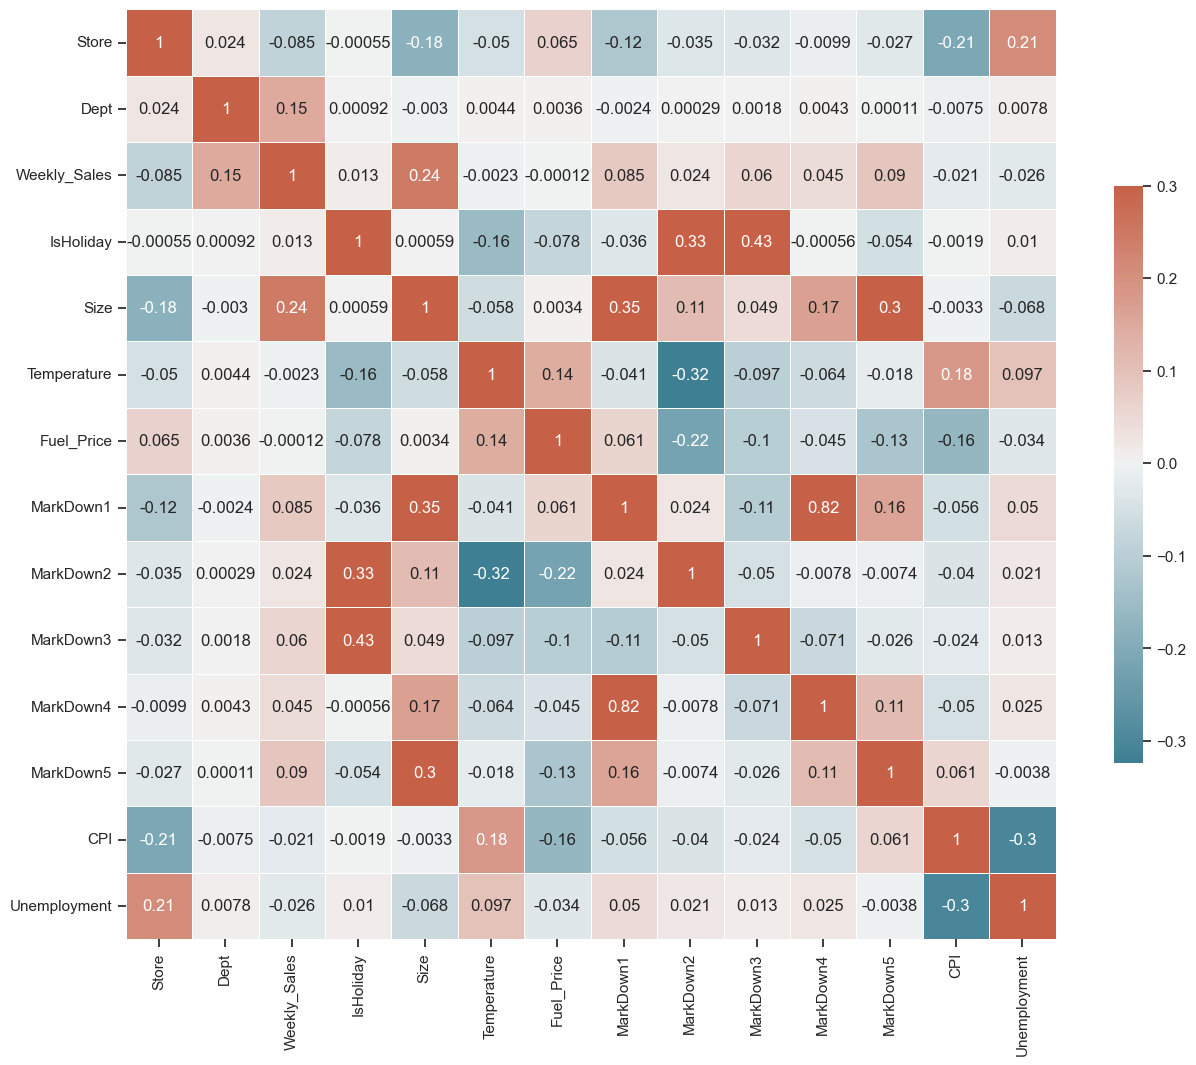

In [77]:
corr = dataset.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

In [78]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [79]:
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Week'] = pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

In [80]:
df = dataset.pop('Weekly_Sales')
dataset['Weekly_Sales'] = df

In [81]:
input_cols, target_col = dataset.columns[:-1], dataset.columns[-1]
inputs_df, targets = dataset[input_cols].copy(), dataset[target_col].copy()

In [82]:
numeric_cols = dataset[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = dataset[input_cols].select_dtypes(include='object').columns.tolist()

In [83]:
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

In [84]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

/Users/neelashasen/miniforge3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [85]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
rf1 = RandomForestRegressor(random_state=0, n_estimators=10)

In [88]:
rf1.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=10, random_state=0)

In [94]:
rf1_train_preds = rf1.predict(train_inputs)

In [95]:
from sklearn.metrics import mean_squared_error

rf1_train_rmse = mean_squared_error(train_targets, rf1_train_preds, squared=False)

In [96]:
rf1_val_preds = rf1.predict(val_inputs)

In [97]:
rf1_val_rmse = mean_squared_error(val_targets, rf1_val_preds, squared=False)

In [98]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 1623.964597165322, Validation RMSE: 4003.142402729527


In [99]:
def test_params(**params):
    model = RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=16, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [100]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

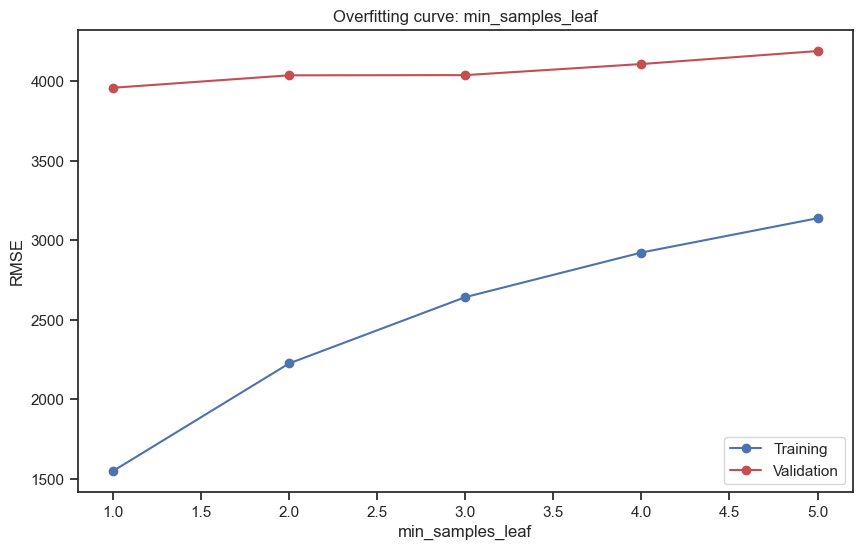

In [101]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5])

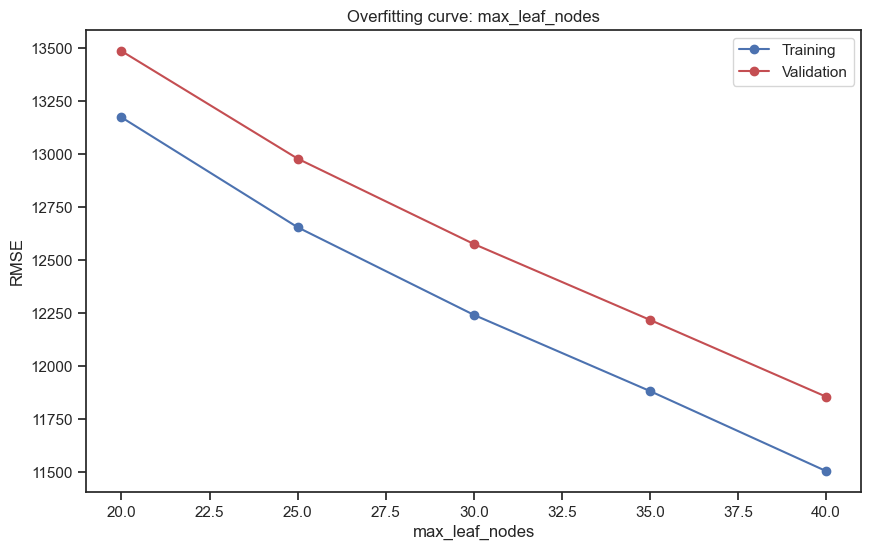

In [102]:
test_param_and_plot('max_leaf_nodes', [20, 25, 30, 35, 40])

In [103]:
rf2 = RandomForestRegressor(n_estimators=16, random_state = 0, min_samples_leaf = 1)

In [104]:
rf2.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=16, random_state=0)

In [105]:
rf2_train_preds = rf2.predict(train_inputs)

In [106]:
rf2_train_rmse = mean_squared_error(train_targets, rf2_train_preds, squared=False)

In [107]:
rf2_val_preds = rf2.predict(val_inputs)

In [108]:
rf2_val_rmse = mean_squared_error(val_targets, rf2_val_preds, squared=False)

In [109]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 1549.418461842585, Validation RMSE: 3960.0543056009674


In [110]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

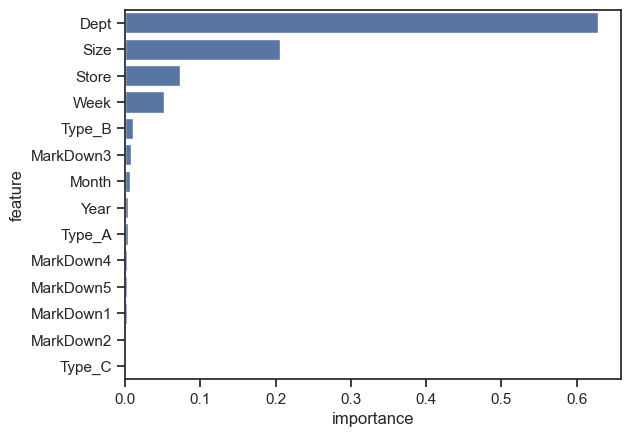

In [124]:
ax = sns.barplot(data=rf2_importance_df, x='importance', y='feature')
fig = ax.get_figure()
fig.savefig('feature_importance.png')

In [112]:
test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
test_dataset['Year'] = pd.to_datetime(test_dataset['Date']).dt.year
test_dataset['Month'] = pd.to_datetime(test_dataset['Date']).dt.month
test_dataset['Week'] = pd.to_datetime(test_dataset['Date']).dt.isocalendar().week
test_dataset = test_dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

In [113]:
test_dataset[numeric_cols] = imputer.transform(test_dataset[numeric_cols])
test_dataset[numeric_cols] = scaler.transform(test_dataset[numeric_cols])
test_dataset[encoded_cols] = encoder.transform(test_dataset[categorical_cols])

In [114]:
test_inputs = test_dataset[numeric_cols + encoded_cols]

In [115]:
test_preds = rf2.predict(test_inputs)

In [116]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols].values)
    return model.predict(input_df[numeric_cols + encoded_cols])[0]

In [117]:
sample_input = {'Store':9, 'Dept':72, 'IsHoliday':True, 'Type':'B', 'Size':125833, 'MarkDown1':2.5, 'MarkDown2':0.02, 
                'MarkDown3':55952.99, 'MarkDown4':14.64, 'MarkDown5':310.72, 'Year':2012, 'Month':11, 'Week':47}

In [118]:
predicted_price = predict_input(rf2, sample_input)

/Users/neelashasen/miniforge3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [119]:
print('The predicted weekly sales is ${}'.format(predicted_price))

The predicted weekly sales is $472348.63687500014


In [120]:
import joblib

In [121]:
walmart_sales_rf = {
    'model': rf2,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [122]:
joblib.dump(walmart_sales_rf, 'walmart_sales_rf.joblib')

['walmart_sales_rf.joblib']